In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


### Model Evaluation and Performance Analysis

This section outlines the evaluation of multiple machine learning models on the loan status prediction task using a test dataset. The process includes data preparation, feature engineering, model loading, predictions, and performance metrics calculation.

- **Data Preparation**:
  - The test dataset is loaded and processed by creating new features such as `loan_to_income` and binning `cibil_score` into categories.
  - Missing values are filled with the mean of numeric columns.
  - Categorical variables are converted into dummy variables for model compatibility.

- **Feature Alignment**:
  - A function `align_features_with_model` ensures that the features in the test set match those expected by each trained model. Missing features are filled with zeros.

- **Scaling**:
  - Features are standardized using `StandardScaler` to improve model performance.

- **Model Evaluation**:
  - Three models (Logistic Regression, Random Forest, Ensemble Model) are loaded from pickle files.
  - For each model:
      - Predictions are made on the aligned test set.
      - Performance metrics such as Accuracy, Precision, Recall, F1 Score, ROC-AUC score, and Confusion Matrix are calculated and displayed.

- **ROC Curve Visualization**:
  - The ROC curves for each model are plotted to visually assess their performance across different thresholds. The area under the curve (AUC) is also displayed.

- **Summary of Results**:
  - A summary DataFrame is created to compare the performance metrics of all models.
  - The best-performing model is identified based on the highest ROC-AUC score.

This analysis provides insights into how well each model predicts loan defaults and highlights the most effective approach for this classification task.



Model: Logistic Regression
Accuracy: 0.4927
Precision: 0.6739
Recall: 0.3987
F1 Score: 0.5010
ROC-AUC: 0.5000
Confusion Matrix:
[[2013 1042]
 [3247 2153]]

Model: Random Forest
Accuracy: 0.6387
Precision: 0.6387
Recall: 1.0000
F1 Score: 0.7795
ROC-AUC: 0.6025
Confusion Matrix:
[[   0 3055]
 [   0 5400]]

Model: Ensemble Model
Accuracy: 0.6387
Precision: 0.6387
Recall: 1.0000
F1 Score: 0.7795
ROC-AUC: 0.5000
Confusion Matrix:
[[   0 3055]
 [   0 5400]]


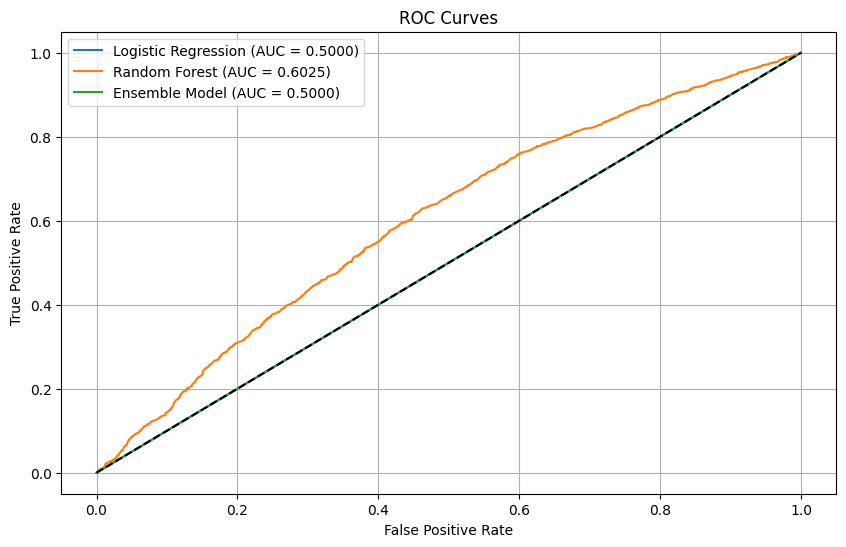


Summary of Model Performance:
                     Accuracy Precision    Recall  F1 Score   ROC-AUC  \
Logistic Regression  0.492726  0.673865  0.398704  0.500989       0.5   
Random Forest        0.638675  0.638675       1.0  0.779502  0.602547   
Ensemble Model       0.638675  0.638675       1.0  0.779502       0.5   

                                 Confusion Matrix  
Logistic Regression  [[2013, 1042], [3247, 2153]]  
Random Forest              [[0, 3055], [0, 5400]]  
Ensemble Model             [[0, 3055], [0, 5400]]  

Best Model Based on ROC-AUC: Random Forest


In [13]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt


test_data = pd.read_excel('test_data.xlsx')


test_data['loan_to_income'] = test_data['loan_amnt'] / (test_data['annual_inc'] + 1)
test_data['cibil_score_bin'] = pd.cut(
    test_data['cibil_score'], bins=[300, 600, 750, 900], labels=['Low', 'Medium', 'High'], include_lowest=True
)
test_data.fillna(test_data.mean(numeric_only=True), inplace=True)
categorical_cols = test_data.select_dtypes(include=['category', 'object']).columns
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)


X_test = test_data.drop(columns=['customer_id', 'transaction_date', 'loan_status'])
y_test = test_data['loan_status']


def align_features_with_model(model, X_test):
    """Align test features with the model's expected feature set."""
    expected_features = model.feature_names_in_
    X_test_aligned = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)


    for feature in expected_features:
        if feature not in X_test_aligned.columns:
            X_test_aligned[feature] = 0


    X_test_aligned = X_test_aligned[expected_features]

    return X_test_aligned


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)


model_files = {
    'Logistic Regression': 'logisticregression_model.pkl',
    'Random Forest': 'randomforest_model.pkl',
    'Ensemble Model': 'advanced_ensemble_model.pkl'
}

results = {}

for model_name, file_name in model_files.items():

    with open(file_name, 'rb') as f:
        model = pickle.load(f)


    X_test_aligned = align_features_with_model(model, pd.DataFrame(X_test_scaled, columns=X_test.columns))


    y_pred = model.predict(X_test_aligned)
    y_proba = model.predict_proba(X_test_aligned)[:, 1]


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm
    }


    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")


plt.figure(figsize=(10, 6))
for model_name, file_name in model_files.items():
    with open(file_name, 'rb') as f:
        model = pickle.load(f)


    X_test_aligned = align_features_with_model(model, pd.DataFrame(X_test_scaled, columns=X_test.columns))

    y_proba = model.predict_proba(X_test_aligned)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['ROC-AUC']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()


results_df = pd.DataFrame(results).T
print("\nSummary of Model Performance:")
print(results_df)


best_model = results_df['ROC-AUC'].idxmax()
print(f"\nBest Model Based on ROC-AUC: {best_model}")


Model: Logistic Regression
Accuracy: 0.5092
Precision: 0.6612
Recall: 0.4644
F1 Score: 0.5456
ROC-AUC: 0.5000
Confusion Matrix:
[[1164  819]
 [1843 1598]]

Model: Random Forest
Accuracy: 0.6344
Precision: 0.6344
Recall: 1.0000
F1 Score: 0.7763
ROC-AUC: 0.6087
Confusion Matrix:
[[   0 1983]
 [   0 3441]]

Model: Ensemble Model
Accuracy: 0.6344
Precision: 0.6344
Recall: 1.0000
F1 Score: 0.7763
ROC-AUC: 0.5000
Confusion Matrix:
[[   0 1983]
 [   0 3441]]


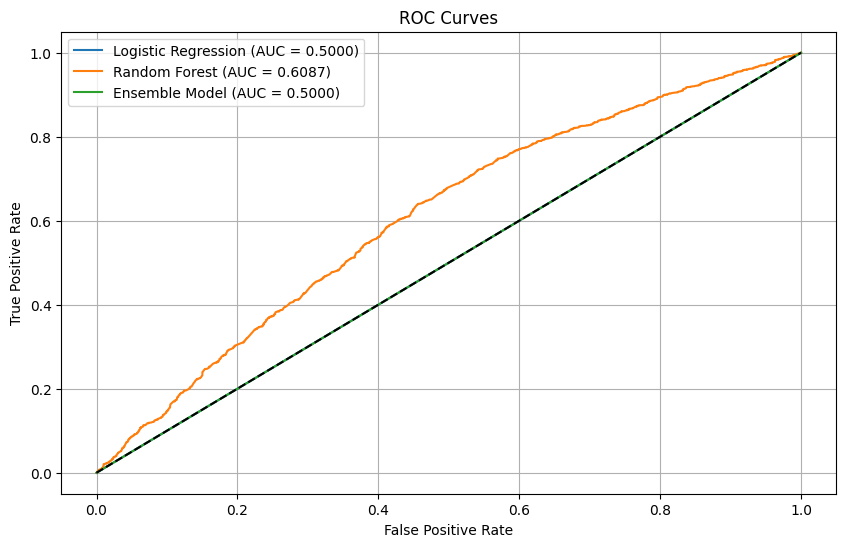


Summary of Model Performance:
                     Accuracy Precision  Recall  F1 Score   ROC-AUC  \
Logistic Regression  0.509218   0.66115  0.4644  0.545579       0.5   
Random Forest        0.634403  0.634403     1.0  0.776311  0.608707   
Ensemble Model       0.634403  0.634403     1.0  0.776311       0.5   

                                Confusion Matrix  
Logistic Regression  [[1164, 819], [1843, 1598]]  
Random Forest             [[0, 1983], [0, 3441]]  
Ensemble Model            [[0, 1983], [0, 3441]]  

Best Model Based on ROC-AUC: Random Forest


In [15]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt


test_data = pd.read_excel('cleaned_test_data.xlsx')


test_data['loan_to_income'] = test_data['loan_amnt'] / (test_data['annual_inc'] + 1)
test_data['cibil_score_bin'] = pd.cut(
    test_data['cibil_score'], bins=[300, 600, 750, 900], labels=['Low', 'Medium', 'High'], include_lowest=True
)
test_data.fillna(test_data.mean(numeric_only=True), inplace=True)
categorical_cols = test_data.select_dtypes(include=['category', 'object']).columns
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)


X_test = test_data.drop(columns=['customer_id', 'transaction_date', 'loan_status'])
y_test = test_data['loan_status']


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)



def align_features_with_model(model, X_test):
    """Align test features with the model's expected feature set."""
    expected_features = model.feature_names_in_
    X_test_aligned = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)


    for feature in expected_features:
        if feature not in X_test_aligned.columns:
            X_test_aligned[feature] = 0


    for feature in X_test_aligned.columns:
        if feature not in expected_features:
            X_test_aligned.drop(columns=[feature], inplace=True)


    X_test_aligned = X_test_aligned[expected_features]

    return X_test_aligned

model_files = {
    'Logistic Regression': 'logisticregression_model.pkl',
    'Random Forest': 'randomforest_model.pkl',
    'Ensemble Model': 'advanced_ensemble_model.pkl'
}

results = {}

for model_name, file_name in model_files.items():

    with open(file_name, 'rb') as f:
        model = pickle.load(f)


    X_test_aligned = align_features_with_model(model, pd.DataFrame(X_test_scaled, columns=X_test.columns))


    y_pred = model.predict(X_test_aligned)
    y_proba = model.predict_proba(X_test_aligned)[:, 1]


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm
    }


    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")


plt.figure(figsize=(10, 6))
for model_name, file_name in model_files.items():
    with open(file_name, 'rb') as f:
        model = pickle.load(f)


    X_test_aligned = align_features_with_model(model, pd.DataFrame(X_test_scaled, columns=X_test.columns))

    y_proba = model.predict_proba(X_test_aligned)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results[model_name]['ROC-AUC']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()


results_df = pd.DataFrame(results).T
print("\nSummary of Model Performance:")
print(results_df)


best_model = results_df['ROC-AUC'].idxmax()
print(f"\nBest Model Based on ROC-AUC: {best_model}")